In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, classification_report
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

import joblib
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Setting the default styling attributes for seaborn
sns.set_theme(style='darkgrid')

In [3]:
# Loading in the dataset
df = pd.read_csv('weatherAUS.csv')

# Exploratory Data Analysis #

In [4]:
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,0.0,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,0.0,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,0.0,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,1.0,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,0.2,No


In [5]:
df.columns

Index(['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RISK_MM', 'RainTomorrow'],
      dtype='object')

In [6]:
df.Date.value_counts()

Date
2017-06-23    49
2013-03-04    49
2014-04-13    49
2014-03-25    49
2017-05-18    49
              ..
2008-01-27     1
2008-01-28     1
2008-01-29     1
2008-01-30     1
2008-01-31     1
Name: count, Length: 3436, dtype: int64

In [7]:
df.Location.nunique()

49

In [8]:
df.RainToday = df.RainToday.map({'No': 0, 'Yes': 1})
df.RainToday.value_counts(normalize=True)

RainToday
0.0    0.776577
1.0    0.223423
Name: proportion, dtype: float64

In [9]:
df.RainTomorrow = df.RainTomorrow.map({'No': 0, 'Yes': 1})
df.RainTomorrow.value_counts(normalize=True)

RainTomorrow
0    0.775819
1    0.224181
Name: proportion, dtype: float64

In [59]:
df_final = df.copy()
X = df_final.drop(columns='RainTomorrow')
y = df_final.RainTomorrow

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

print('Train size:', X_train.shape[0])
print('Test size: ', X_test.shape[0])

Train size: 106644
Test size:  35549


In [39]:
X_train.dtypes

Date              object
Location          object
MinTemp          float64
MaxTemp          float64
Rainfall         float64
Evaporation      float64
Sunshine         float64
WindGustDir       object
WindGustSpeed    float64
WindDir9am        object
WindDir3pm        object
WindSpeed9am     float64
WindSpeed3pm     float64
Humidity9am      float64
Humidity3pm      float64
Pressure9am      float64
Pressure3pm      float64
Cloud9am         float64
Cloud3pm         float64
Temp9am          float64
Temp3pm          float64
RainToday        float64
RISK_MM          float64
dtype: object

In [60]:
X_train

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM
103079,2009-04-12,Woomera,14.9,30.3,0.0,7.4,10.9,S,33.0,ESE,...,19.0,12.0,1021.1,1017.8,1.0,1.0,22.2,29.7,0.0,0.0
111021,2014-12-08,Witchcliffe,14.6,21.5,0.2,NaN,NaN,SSE,46.0,S,...,65.0,57.0,1012.6,1013.5,NaN,NaN,17.5,18.6,0.0,0.2
123110,2015-06-06,SalmonGums,9.0,23.7,0.0,NaN,NaN,W,28.0,WNW,...,59.0,45.0,NaN,NaN,NaN,NaN,14.6,23.1,0.0,0.0
107740,2014-01-09,Albany,15.3,24.0,0.0,8.2,12.1,NaN,NaN,SSW,...,63.0,82.0,1018.1,1016.7,3.0,3.0,21.8,21.8,0.0,0.0
70263,2014-12-14,Mildura,17.3,37.5,0.0,8.6,11.4,N,39.0,NE,...,26.0,12.0,1009.6,1006.2,7.0,4.0,23.8,35.7,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110268,2012-09-01,Witchcliffe,9.0,18.9,12.6,NaN,NaN,W,43.0,WNW,...,NaN,NaN,1017.5,1017.7,NaN,NaN,15.8,17.6,1.0,2.6
119879,2014-09-09,Perth,13.1,19.9,3.0,1.2,2.3,SW,39.0,SW,...,90.0,55.0,1018.1,1018.2,7.0,7.0,15.4,19.1,1.0,0.2
103694,2010-12-20,Woomera,10.8,25.5,0.0,12.0,13.0,SSW,44.0,SSW,...,41.0,21.0,1015.7,1012.6,0.0,0.0,15.3,23.1,0.0,0.0
131932,2014-11-05,Launceston,11.3,21.4,0.0,NaN,NaN,ESE,39.0,SSE,...,75.0,79.0,NaN,NaN,8.0,4.0,15.8,15.7,0.0,3.2


## Histograms ##

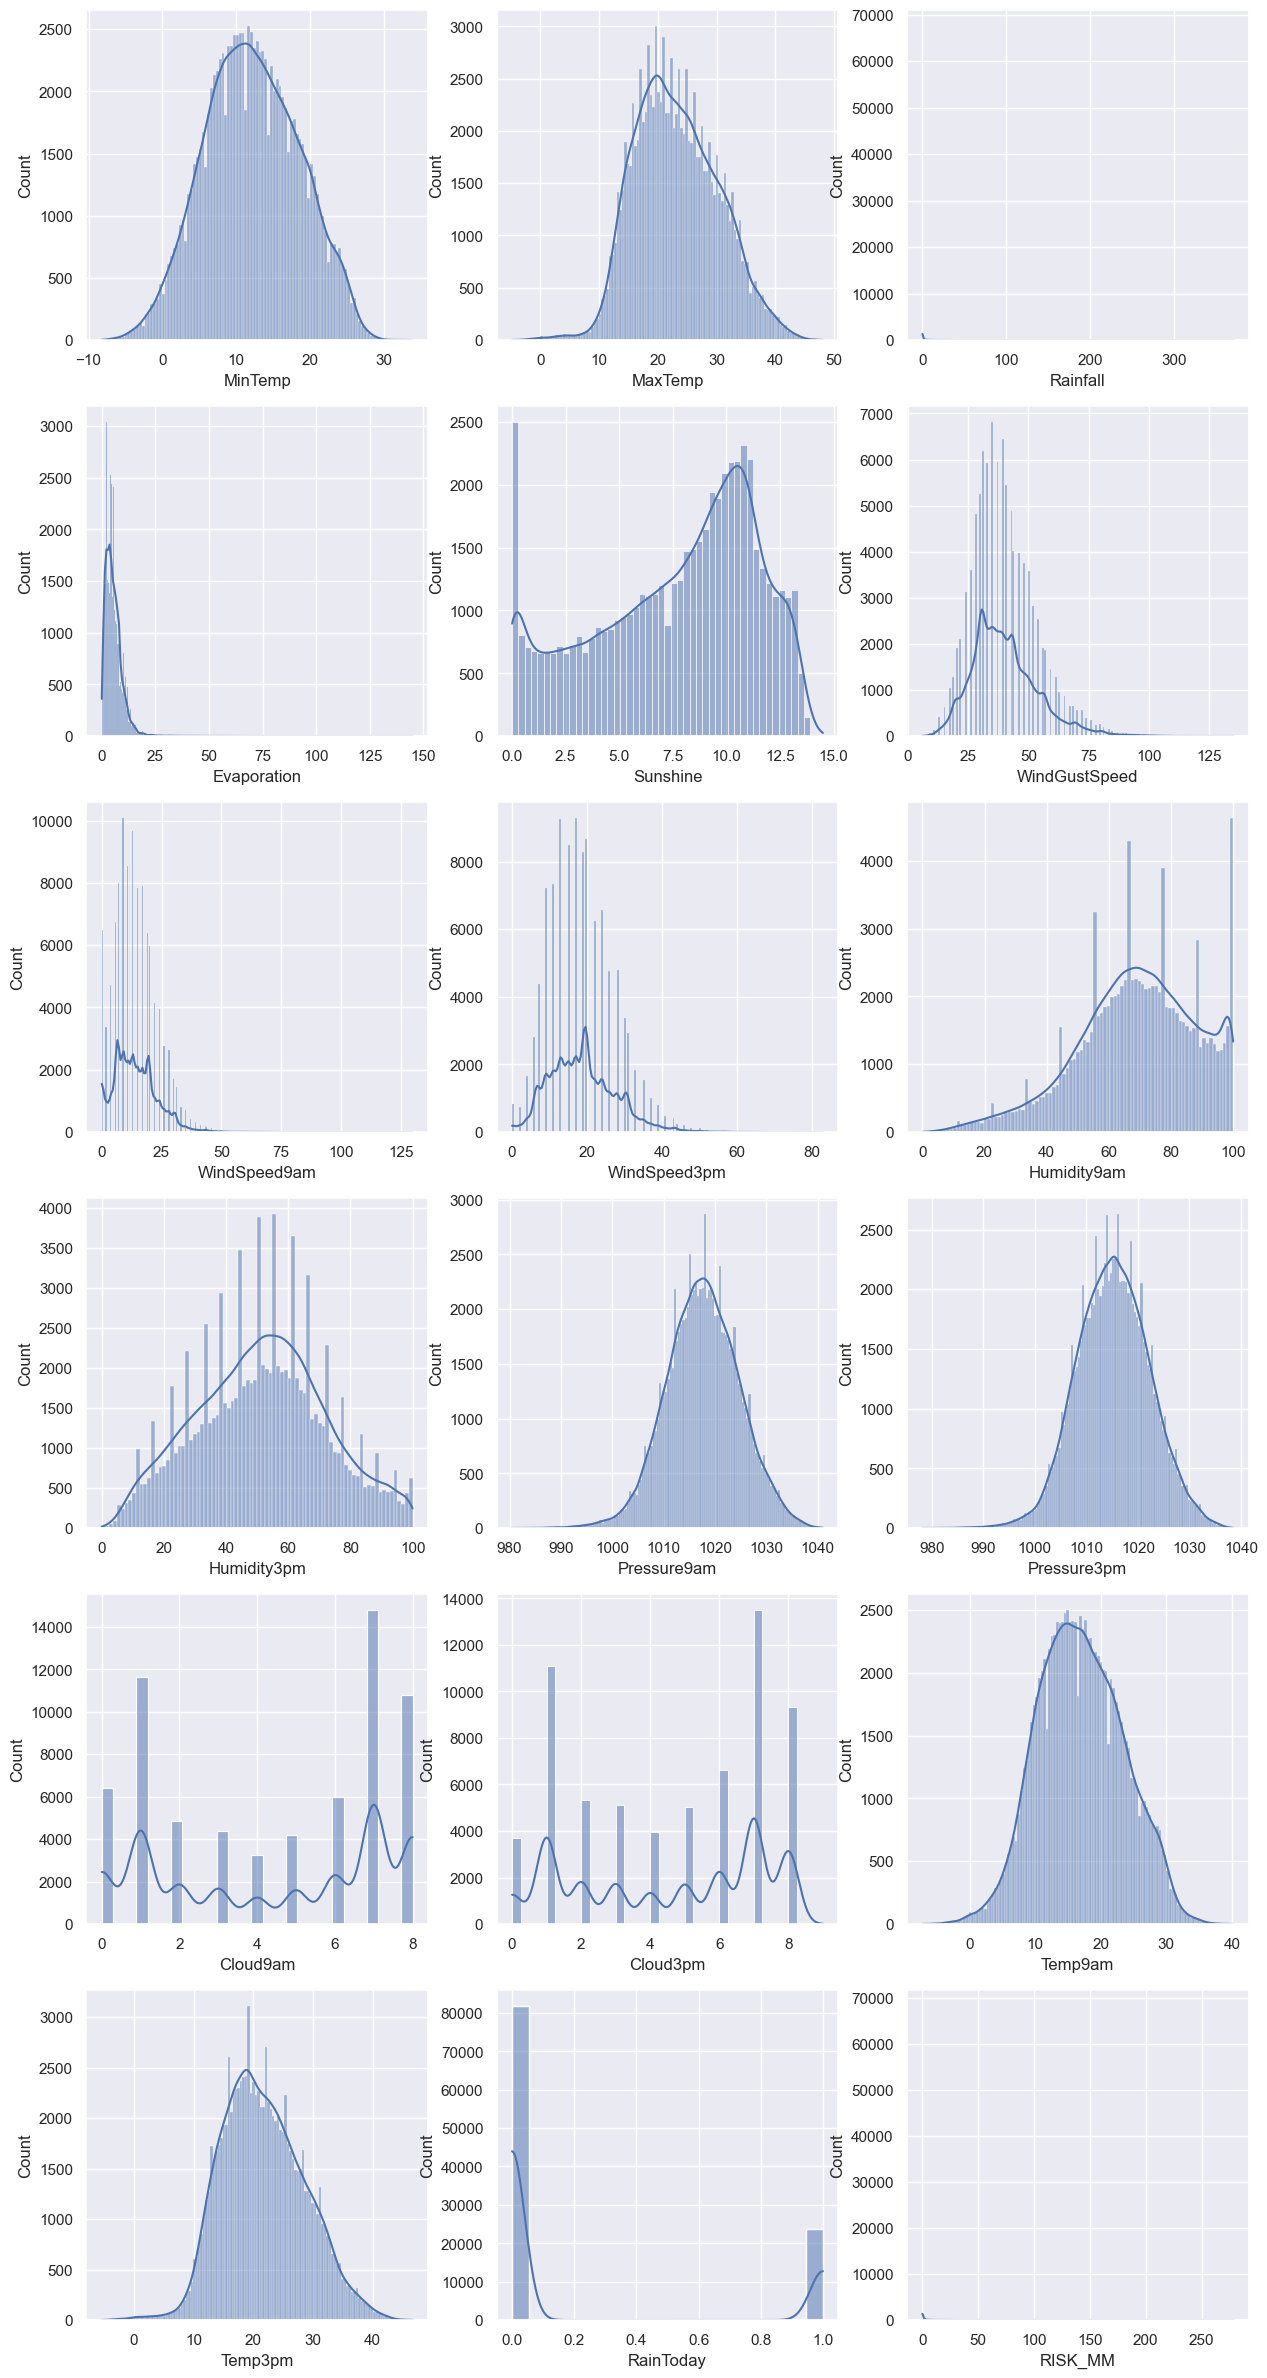

In [40]:
import math
continuous = [col for col in X_train.columns if X_train[col].dtype != object]

n_cols = 3
n_rows = math.ceil(len(continuous) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten()

for i, col in enumerate(continuous):
    sns.histplot(X_train[col], ax=axes[i], kde=True)

plt.show()


In [41]:
df_rain_by_loc = X_train.groupby(by='Location').sum()
df_rain_by_loc = df_rain_by_loc[['RainToday']]
df_rain_by_loc.head()

,RainToday
Location,
Adelaide,515.0
Albany,674.0
Albury,446.0
AliceSprings,182.0
BadgerysCreek,438.0


In [42]:
plt.figure(figsize=(8, 12))
sns.barplot(x='RainToday', 
            y=df_rain_by_loc.index, 
            data=df_rain_by_loc.sort_values('RainToday', ascending=False), 
            orient='h',
            palette='crest'
           )
plt.xlabel('Number of Days')
plt.title('Rainy Days by Location')
plt.tight_layout()
plt.savefig('images/rainy_days_by_loc.png', facecolor='white', dpi=100);

In [43]:
X_train.Location.value_counts()

Location
Canberra            2578
Sydney              2429
Hobart              2416
Perth               2408
Brisbane            2401
Darwin              2382
Adelaide            2329
Tuggeranong         2298
Mildura             2295
Bendigo             2279
Launceston          2279
PerthAirport        2269
Woomera             2266
Ballarat            2262
Albany              2255
MountGambier        2254
Townsville          2248
CoffsHarbour        2247
MelbourneAirport    2246
Watsonia            2243
Sale                2241
GoldCoast           2240
Witchcliffe         2240
AliceSprings        2237
Portland            2236
WaggaWagga          2236
NorfolkIsland       2236
Cobar               2236
Albury              2234
Penrith             2233
Cairns              2232
BadgerysCreek       2232
Newcastle           2229
Nuriootpa           2224
SydneyAirport       2224
Wollongong          2213
SalmonGums          2206
Richmond            2201
Dartmoor            2200
MountGinini     

## Seasonality ##

In [44]:
df_seasonality = df.copy()
df_seasonality['month'] = df_seasonality.Date.apply(lambda x: int(str(x)[5:7]))
df_seasonality[['Date', 'month']].head()

,Date,month
0,2008-12-01,12
1,2008-12-02,12
2,2008-12-03,12
3,2008-12-04,12
4,2008-12-05,12


In [45]:
df_seasonality_grouped = df_seasonality.groupby('month', as_index=False)[['RainToday']].mean()
df_seasonality_grouped[['RainToday']]

,RainToday
0,0.188872
1,0.206608
2,0.216376
3,0.216146
4,0.220865
5,0.263012
6,0.269897
7,0.252490
8,0.227500
9,0.195986


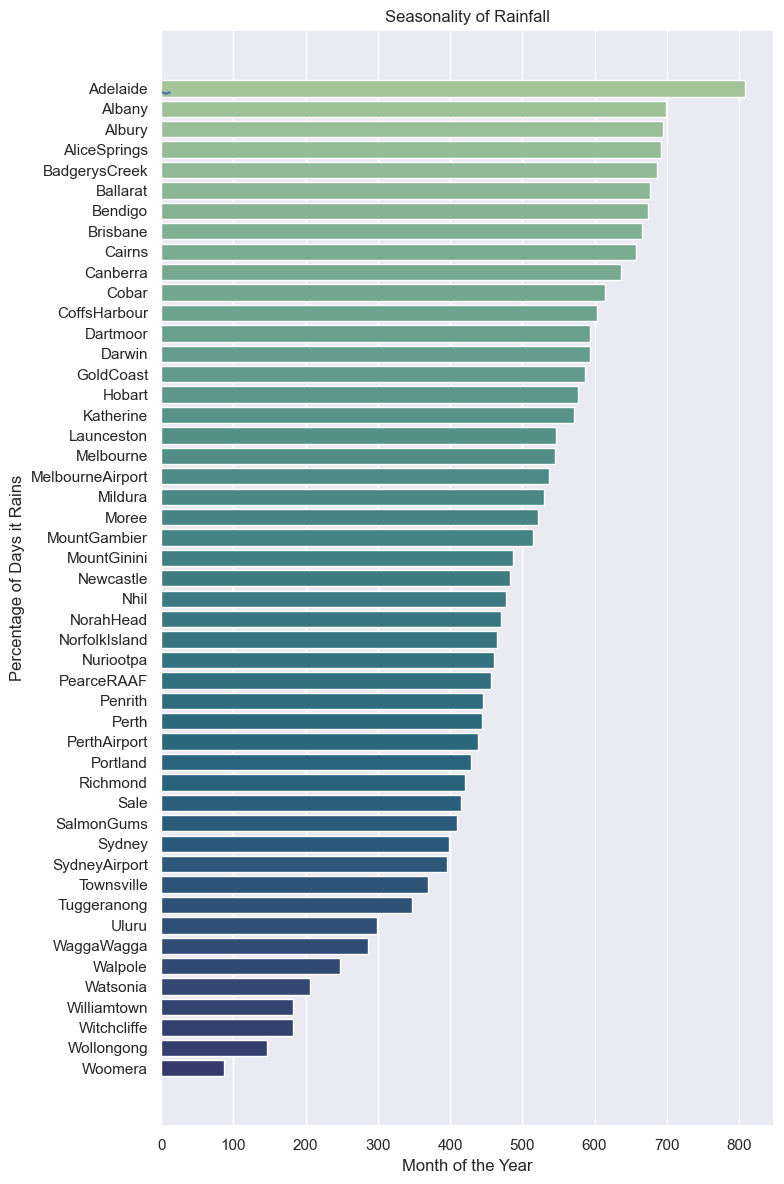

In [46]:
sns.lineplot(data=df_seasonality_grouped, x='month', y='RainToday')
plt.title('Seasonality of Rainfall')
plt.xlabel('Month of the Year')
plt.ylabel('Percentage of Days it Rains')
plt.tight_layout()
plt.savefig('images/seasonality.png', facecolor='white', dpi=100);
plt.show()

## Correlation Matrix ##

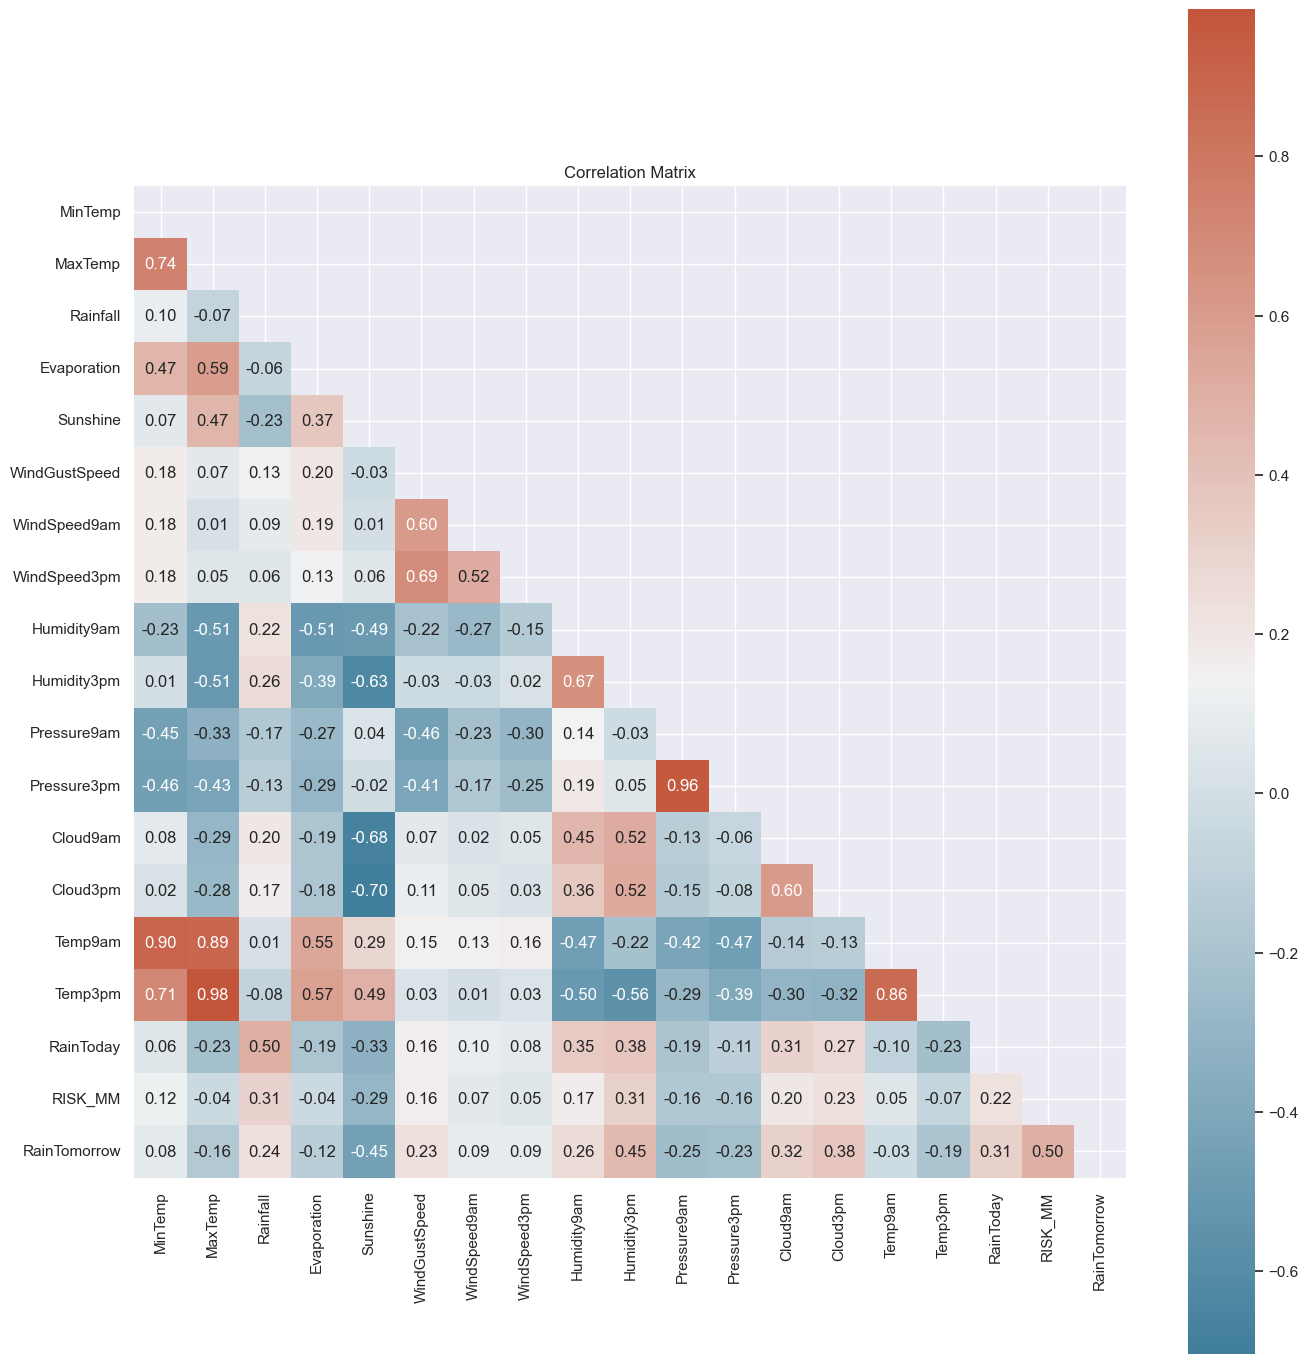

In [47]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(14, 14))
plt.title('Correlation Matrix')

corr = df.select_dtypes(include='number').corr()
# Creating a mask to block the top right half of the heatmap (redundant information)
mask = np.triu(np.ones_like(corr, dtype = bool))

# Custom color map
cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr, mask=mask, annot=True, fmt='.2f', square=True, cmap=cmap)
plt.tight_layout()
plt.savefig('images/corr_heatmap.png', facecolor='white', dpi=100);
plt.show()

In [58]:
X_train.shape

(142193, 23)

In [57]:
X_train.dtypes

Date              object
Location          object
MinTemp          float64
MaxTemp          float64
Rainfall         float64
Evaporation      float64
Sunshine         float64
WindGustDir       object
WindGustSpeed    float64
WindDir9am        object
WindDir3pm        object
WindSpeed9am     float64
WindSpeed3pm     float64
Humidity9am      float64
Humidity3pm      float64
Pressure9am      float64
Pressure3pm      float64
Cloud9am         float64
Cloud3pm         float64
Temp9am          float64
Temp3pm          float64
RainToday        float64
RISK_MM          float64
dtype: object

In [52]:
df.isna().sum()

Date                 0
Location             0
MinTemp            637
MaxTemp            322
Rainfall          1406
Evaporation      60843
Sunshine         67816
WindGustDir       9330
WindGustSpeed     9270
WindDir9am       10013
WindDir3pm        3778
WindSpeed9am      1348
WindSpeed3pm      2630
Humidity9am       1774
Humidity3pm       3610
Pressure9am      14014
Pressure3pm      13981
Cloud9am         53657
Cloud3pm         57094
Temp9am            904
Temp3pm           2726
RainToday         1406
RISK_MM              0
RainTomorrow         0
dtype: int64

In [61]:
X_train.isna().sum()

Date                 0
Location             0
MinTemp            494
MaxTemp            257
Rainfall          1104
Evaporation      45735
Sunshine         50967
WindGustDir       6979
WindGustSpeed     6929
WindDir9am        7524
WindDir3pm        2822
WindSpeed9am       998
WindSpeed3pm      1963
Humidity9am       1318
Humidity3pm       2727
Pressure9am      10546
Pressure3pm      10521
Cloud9am         40359
Cloud3pm         42887
Temp9am            677
Temp3pm           2065
RainToday         1104
RISK_MM              0
dtype: int64

In [63]:
cont_feats = [col for col in X_train.columns if X_train[col].dtype != object]
cont_feats

['MinTemp',
 'MaxTemp',
 'Rainfall',
 'Evaporation',
 'Sunshine',
 'WindGustSpeed',
 'WindSpeed9am',
 'WindSpeed3pm',
 'Humidity9am',
 'Humidity3pm',
 'Pressure9am',
 'Pressure3pm',
 'Cloud9am',
 'Cloud3pm',
 'Temp9am',
 'Temp3pm',
 'RainToday',
 'RISK_MM']

In [205]:
X_test_fl = imputer.transform(X_test_fl[train_list])

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- DOY_cos
- DOY_sin
- DayOfYear
- Location_Adelaide
- Location_Albany
- ...


In [209]:
imputer.fit(X_train_fl)

IterativeImputer(random_state=42)

In [210]:
X_test_fl = imputer.transform(X_test_fl)

In [213]:
X_test_fl = pd.DataFrame(X_test_fl, columns = train_list, index=X_test.index)

In [214]:
X_test_fl.isna().sum()

MinTemp                0
MaxTemp                0
Rainfall               0
Evaporation            0
Sunshine               0
                      ..
Location_Wollongong    0
Location_Woomera       0
DayOfYear              0
DOY_sin                0
DOY_cos                0
Length: 121, dtype: int64

In [77]:
imputer = IterativeImputer(random_state=42)
df_imputed_cont = imputer.fit_transform(X_train[cont_feats])
df_imputed_cont = pd.DataFrame(df_imputed_cont, columns=cont_feats, index=X_train.index)
df_imputed_cont.head()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM
103079,14.9,30.3,0.0,7.400000,10.900000,33.000000,15.0,11.0,19.0,12.0,1021.100000,1017.800000,1.000000,1.000000,22.2,29.7,0.0,0.0
111021,14.6,21.5,0.2,6.532425,7.100367,46.000000,26.0,28.0,65.0,57.0,1012.600000,1013.500000,5.300522,5.276937,17.5,18.6,0.0,0.2
123110,9.0,23.7,0.0,4.982004,8.642455,28.000000,11.0,15.0,59.0,45.0,1020.464581,1016.574411,3.229226,3.415485,14.6,23.1,0.0,0.0
107740,15.3,24.0,0.0,8.200000,12.100000,26.515607,4.0,15.0,63.0,82.0,1018.100000,1016.700000,3.000000,3.000000,21.8,21.8,0.0,0.0
70263,17.3,37.5,0.0,8.600000,11.400000,39.000000,9.0,15.0,26.0,12.0,1009.600000,1006.200000,7.000000,4.000000,23.8,35.7,0.0,0.0


In [78]:
df_imputed_cont.isna().sum()

MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustSpeed    0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
RainToday        0
RISK_MM          0
dtype: int64

## Categorical Features ##

In [66]:
cat_feats = [col for col in X_train.columns if col not in cont_feats]

# Also removing Date and Location since no values are missing
cat_feats.remove('Date')
cat_feats.remove('Location')
cat_feats

['WindGustDir', 'WindDir9am', 'WindDir3pm']

In [68]:
type(X_train)

pandas.core.frame.DataFrame

In [69]:
X_train.index

Index([103079, 111021, 123110, 107740,  70263, 124020,  71945, 102354,  13935,
        50976,
       ...
       126324, 112727,  87498, 137337,  54886, 110268, 119879, 103694, 131932,
       121958],
      dtype='int64', length=106644)

In [70]:
X_train.index.equals(y_train.index)

True

In [71]:
df_imputed_cat = X_train[cat_feats]

for col in df_imputed_cat.columns:
    values = df_imputed_cat.WindDir3pm.value_counts().values
    probs = df_imputed_cat[col].value_counts(normalize=True).values
    df_imputed_cat[col].replace(np.nan, np.random.choice(a=values, p=probs), inplace=True)

df_imputed_cat.head()

,WindGustDir,WindDir9am,WindDir3pm
103079,S,ESE,SW
111021,SSE,S,SSE
123110,W,WNW,W
107740,7189,SSW,SSW
70263,N,NE,NW


In [73]:
df_imputed_cat.isna().sum()

WindGustDir    0
WindDir9am     0
WindDir3pm     0
dtype: int64

In [109]:
df_imputed_cat.dtypes

WindGustDir    object
WindDir9am     object
WindDir3pm     object
dtype: object

In [74]:
df_imputed_cat.index

Index([103079, 111021, 123110, 107740,  70263, 124020,  71945, 102354,  13935,
        50976,
       ...
       126324, 112727,  87498, 137337,  54886, 110268, 119879, 103694, 131932,
       121958],
      dtype='int64', length=106644)

In [79]:
X_train.index.equals(df_imputed_cat.index)

True

In [80]:
X_train.index.equals(df_imputed_cont.index)

True

In [81]:
X_train['Date'].dtype

dtype('O')

In [82]:
X_train['Date'] = pd.to_datetime(X_train['Date'], errors = 'coerce')

In [130]:
X_test.head()

,Date,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Location_Townsville,Location_Tuggeranong,Location_Uluru,Location_WaggaWagga,Location_Walpole,Location_Watsonia,Location_Williamtown,Location_Witchcliffe,Location_Wollongong,Location_Woomera
56320,2016-06-09,7.1,13.0,8.8,NaN,NaN,N,41.0,N,WNW,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
124136,2009-10-24,13.2,18.3,0.0,NaN,NaN,E,48.0,ESE,ESE,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
117063,2015-09-21,9.2,22.7,0.0,5.0,11.1,ENE,52.0,ENE,ESE,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6974,2011-12-06,15.3,26.1,0.0,10.4,NaN,E,44.0,E,NE,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
61546,2014-03-15,11.9,31.8,0.0,5.0,4.1,NW,72.0,E,N,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [132]:
X_train.head()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,...,Location_Tuggeranong,Location_Uluru,Location_WaggaWagga,Location_Walpole,Location_Watsonia,Location_Williamtown,Location_Witchcliffe,Location_Wollongong,Location_Woomera,Date
103079,14.9,30.3,0.0,7.4,10.9,S,33.0,ESE,SW,15.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2009-04-12
111021,14.6,21.5,0.2,NaN,NaN,SSE,46.0,S,SSE,26.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2014-12-08
123110,9.0,23.7,0.0,NaN,NaN,W,28.0,WNW,W,11.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2015-06-06
107740,15.3,24.0,0.0,8.2,12.1,NaN,NaN,SSW,SSW,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2014-01-09
70263,17.3,37.5,0.0,8.6,11.4,N,39.0,NE,NW,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2014-12-14


In [131]:
X_train['Date'] = date

In [134]:
X_train['DayOfYear'] = X_train['Date'].dt.dayofyear
X_train['DOY_sin']   = np.sin(2 * np.pi * X_train['DayOfYear'] / 365)
X_train['DOY_cos']   = np.cos(2 * np.pi * X_train['DayOfYear'] / 365)

In [87]:
date = X_train['Date']

In [135]:
date_cols = ['DayOfYear','DOY_sin','DOY_cos']

In [89]:
X_train.dtypes

Location          object
MinTemp          float64
MaxTemp          float64
Rainfall         float64
Evaporation      float64
Sunshine         float64
WindGustDir       object
WindGustSpeed    float64
WindDir9am        object
WindDir3pm        object
WindSpeed9am     float64
WindSpeed3pm     float64
Humidity9am      float64
Humidity3pm      float64
Pressure9am      float64
Pressure3pm      float64
Cloud9am         float64
Cloud3pm         float64
Temp9am          float64
Temp3pm          float64
RainToday        float64
RISK_MM          float64
DayOfYear          int32
DOY_sin          float64
DOY_cos          float64
dtype: object

In [90]:
X_train['Location'].nunique()

49

In [91]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(
    handle_unknown = 'ignore',
    sparse_output = False
)

In [92]:
loc_train = ohe.fit_transform(X_train[['Location']])
loc_test = ohe.transform(X_test[['Location']])

In [96]:
loc_cols = ohe.get_feature_names_out(['Location'])
loc_train = pd.DataFrame(loc_train, columns=loc_cols, index=X_train.index)
loc_test = pd.DataFrame(loc_test, columns=loc_cols, index=X_test.index)

In [98]:
X_train = X_train.drop(columns=['Location']).join(loc_train)
X_test = X_test.drop(columns=['Location']).join(loc_test)

In [ ]:
df_cat = ohe.fit_transform(df_imputed_cat[['']])

In [111]:
cat_cols = ['WindGustDir','WindDir9am','WindDir3pm']

In [112]:
cat_train = ohe.fit_transform(X_train[cat_cols])
cat_test = ohe.transform(X_test[cat_cols])

In [113]:
cat_cols_encoded = ohe.get_feature_names_out(cat_cols)

In [114]:
cat_train = pd.DataFrame(
    cat_train,
    columns=cat_cols_encoded,
    index=X_train.index
)

cat_test = pd.DataFrame(
    cat_test,
    columns=cat_cols_encoded,
    index=X_test.index
)


In [117]:
loc_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 106644 entries, 103079 to 121958
Data columns (total 49 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Location_Adelaide          106644 non-null  float64
 1   Location_Albany            106644 non-null  float64
 2   Location_Albury            106644 non-null  float64
 3   Location_AliceSprings      106644 non-null  float64
 4   Location_BadgerysCreek     106644 non-null  float64
 5   Location_Ballarat          106644 non-null  float64
 6   Location_Bendigo           106644 non-null  float64
 7   Location_Brisbane          106644 non-null  float64
 8   Location_Cairns            106644 non-null  float64
 9   Location_Canberra          106644 non-null  float64
 10  Location_Cobar             106644 non-null  float64
 11  Location_CoffsHarbour      106644 non-null  float64
 12  Location_Dartmoor          106644 non-null  float64
 13  Location_Darwin            10

## Concatnating ##

In [136]:
X_train_fl = pd.concat([df_imputed_cont,cat_train,loc_train,X_train[date_cols]], axis=1)

In [137]:
X_train_fl.columns

Index(['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm',
       ...
       'Location_WaggaWagga', 'Location_Walpole', 'Location_Watsonia',
       'Location_Williamtown', 'Location_Witchcliffe', 'Location_Wollongong',
       'Location_Woomera', 'DayOfYear', 'DOY_sin', 'DOY_cos'],
      dtype='object', length=121)

In [196]:
X_test_fl = pd.concat([X_test, cat_test], axis=1)

In [189]:
X_train_fl = pd.DataFrame(X_train_fl, columns = train_list, index = X_train.index)

In [190]:
X_train_fl.head()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,...,Location_WaggaWagga,Location_Walpole,Location_Watsonia,Location_Williamtown,Location_Witchcliffe,Location_Wollongong,Location_Woomera,DayOfYear,DOY_sin,DOY_cos
103079,14.9,30.3,0.0,7.400000,10.900000,33.000000,15.0,11.0,19.0,12.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,102,0.982927,-0.183998
111021,14.6,21.5,0.2,6.532425,7.100367,46.000000,26.0,28.0,65.0,57.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,342,-0.385663,0.922640
123110,9.0,23.7,0.0,4.982004,8.642455,28.000000,11.0,15.0,59.0,45.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,157,0.425000,-0.905193
107740,15.3,24.0,0.0,8.200000,12.100000,26.515607,4.0,15.0,63.0,82.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9,0.154309,0.988023
70263,17.3,37.5,0.0,8.600000,11.400000,39.000000,9.0,15.0,26.0,12.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,348,-0.288482,0.957485


In [167]:
train_list = X_train_fl.columns.tolist()

In [168]:
train_list

['MinTemp',
 'MaxTemp',
 'Rainfall',
 'Evaporation',
 'Sunshine',
 'WindGustSpeed',
 'WindSpeed9am',
 'WindSpeed3pm',
 'Humidity9am',
 'Humidity3pm',
 'Pressure9am',
 'Pressure3pm',
 'Cloud9am',
 'Cloud3pm',
 'Temp9am',
 'Temp3pm',
 'RainToday',
 'RISK_MM',
 'WindGustDir_E',
 'WindGustDir_ENE',
 'WindGustDir_ESE',
 'WindGustDir_N',
 'WindGustDir_NE',
 'WindGustDir_NNE',
 'WindGustDir_NNW',
 'WindGustDir_NW',
 'WindGustDir_S',
 'WindGustDir_SE',
 'WindGustDir_SSE',
 'WindGustDir_SSW',
 'WindGustDir_SW',
 'WindGustDir_W',
 'WindGustDir_WNW',
 'WindGustDir_WSW',
 'WindGustDir_nan',
 'WindDir9am_E',
 'WindDir9am_ENE',
 'WindDir9am_ESE',
 'WindDir9am_N',
 'WindDir9am_NE',
 'WindDir9am_NNE',
 'WindDir9am_NNW',
 'WindDir9am_NW',
 'WindDir9am_S',
 'WindDir9am_SE',
 'WindDir9am_SSE',
 'WindDir9am_SSW',
 'WindDir9am_SW',
 'WindDir9am_W',
 'WindDir9am_WNW',
 'WindDir9am_WSW',
 'WindDir9am_nan',
 'WindDir3pm_E',
 'WindDir3pm_ENE',
 'WindDir3pm_ESE',
 'WindDir3pm_N',
 'WindDir3pm_NE',
 'WindDir3pm_

In [188]:
X_train.head()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,...,Location_Townsville,Location_Tuggeranong,Location_Uluru,Location_WaggaWagga,Location_Walpole,Location_Watsonia,Location_Williamtown,Location_Witchcliffe,Location_Wollongong,Location_Woomera
103079,14.9,30.3,0.0,7.4,10.9,S,33.0,ESE,SW,15.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
111021,14.6,21.5,0.2,NaN,NaN,SSE,46.0,S,SSE,26.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
123110,9.0,23.7,0.0,NaN,NaN,W,28.0,WNW,W,11.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
107740,15.3,24.0,0.0,8.2,12.1,NaN,NaN,SSW,SSW,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
70263,17.3,37.5,0.0,8.6,11.4,N,39.0,NE,NW,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [150]:
X_train = X_train.drop(['Date'], axis=1)

In [207]:
X_train_fl.head()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,...,Location_WaggaWagga,Location_Walpole,Location_Watsonia,Location_Williamtown,Location_Witchcliffe,Location_Wollongong,Location_Woomera,DayOfYear,DOY_sin,DOY_cos
103079,14.9,30.3,0.0,7.400000,10.900000,33.000000,15.0,11.0,19.0,12.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,102,0.982927,-0.183998
111021,14.6,21.5,0.2,6.532425,7.100367,46.000000,26.0,28.0,65.0,57.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,342,-0.385663,0.922640
123110,9.0,23.7,0.0,4.982004,8.642455,28.000000,11.0,15.0,59.0,45.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,157,0.425000,-0.905193
107740,15.3,24.0,0.0,8.200000,12.100000,26.515607,4.0,15.0,63.0,82.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9,0.154309,0.988023
70263,17.3,37.5,0.0,8.600000,11.400000,39.000000,9.0,15.0,26.0,12.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,348,-0.288482,0.957485


In [206]:
X_test_fl.head()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,...,Location_WaggaWagga,Location_Walpole,Location_Watsonia,Location_Williamtown,Location_Witchcliffe,Location_Wollongong,Location_Woomera,DayOfYear,DOY_sin,DOY_cos
56320,7.1,13.0,8.8,NaN,NaN,41.0,24.0,22.0,100.0,98.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,161,0.361714,-0.932289
124136,13.2,18.3,0.0,NaN,NaN,48.0,24.0,20.0,73.0,73.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,297,-0.920971,0.389630
117063,9.2,22.7,0.0,5.0,11.1,52.0,26.0,20.0,45.0,25.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,264,-0.985948,-0.167052
6974,15.3,26.1,0.0,10.4,NaN,44.0,24.0,19.0,48.0,40.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,340,-0.417194,0.908818
61546,11.9,31.8,0.0,5.0,4.1,72.0,6.0,19.0,89.0,25.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,74,0.956235,0.292600


In [139]:
X_train_fl.isna().sum()

MinTemp                0
MaxTemp                0
Rainfall               0
Evaporation            0
Sunshine               0
                      ..
Location_Wollongong    0
Location_Woomera       0
DayOfYear              0
DOY_sin                0
DOY_cos                0
Length: 121, dtype: int64

In [199]:
X_test_fl = X_test_fl.drop(cat_cols, axis=1)

In [165]:
X_train_fl.info()

<class 'pandas.core.frame.DataFrame'>
Index: 106644 entries, 103079 to 121958
Columns: 121 entries, MinTemp to DOY_cos
dtypes: float64(120), int32(1)
memory usage: 102.9 MB


In [164]:
X_test_fl.info()

<class 'pandas.core.frame.DataFrame'>
Index: 35549 entries, 56320 to 59318
Columns: 121 entries, MinTemp to WindDir3pm_nan
dtypes: float64(120), int32(1)
memory usage: 34.0 MB


In [200]:
X_test_fl.info()

<class 'pandas.core.frame.DataFrame'>
Index: 35549 entries, 56320 to 59318
Columns: 121 entries, MinTemp to WindDir3pm_nan
dtypes: float64(120), int32(1)
memory usage: 34.0 MB


In [198]:
X_test_fl = X_test_fl.drop(['Date'], axis=1)

In [201]:
X_train_fl.columns.equals(X_test_fl.columns)

False

In [202]:
set(X_train_fl.columns) == set(X_test_fl.columns)   # True

True

In [203]:
X_test_fl = X_test_fl[X_train_fl.columns]

In [204]:
X_train_fl.columns.equals(X_test_fl.columns)

True

In [194]:
type(X_test)

numpy.ndarray

In [195]:
X_test_fl.shape

(35549, 18)

In [192]:
X_test_fl = pd.DataFrame(X_test_fl, columns = test_list, index = X_train.index)

ValueError: Shape of passed values is (35549, 18), indices imply (106644, 121)

In [185]:
test_list = X_test_fl.columns.tolist()
test_list

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

In [142]:
X_test.head()

,Date,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Location_Townsville,Location_Tuggeranong,Location_Uluru,Location_WaggaWagga,Location_Walpole,Location_Watsonia,Location_Williamtown,Location_Witchcliffe,Location_Wollongong,Location_Woomera
56320,2016-06-09,7.1,13.0,8.8,NaN,NaN,N,41.0,N,WNW,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
124136,2009-10-24,13.2,18.3,0.0,NaN,NaN,E,48.0,ESE,ESE,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
117063,2015-09-21,9.2,22.7,0.0,5.0,11.1,ENE,52.0,ENE,ESE,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6974,2011-12-06,15.3,26.1,0.0,10.4,NaN,E,44.0,E,NE,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
61546,2014-03-15,11.9,31.8,0.0,5.0,4.1,NW,72.0,E,N,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [144]:
X_test['Date'] = pd.to_datetime(X_test['Date'], errors = 'coerce')

In [145]:
X_test['DayOfYear'] = X_test['Date'].dt.dayofyear
X_test['DOY_sin']   = np.sin(2 * np.pi * X_test['DayOfYear'] / 365)
X_test['DOY_cos']   = np.cos(2 * np.pi * X_test['DayOfYear'] / 365)

In [223]:
X_train_fl = X_train_fl.drop(['RISK_MM'], axis=1)
X_test_fl = X_test_fl.drop(['RISK_MM'], axis=1)

## Scaling data ##

In [176]:
from sklearn.preprocessing import StandardScaler

In [177]:
scaler = StandardScaler()

In [224]:
X_train_scaled = scaler.fit_transform(X_train_fl)
X_test_scaled = scaler.transform(X_test_fl)

## Model Logistic Regression ##

In [225]:
logreg = LogisticRegression(random_state=42)
logreg.fit(X_train_scaled, y_train)
y_pred = logreg.predict(X_test_scaled)
y_pred

array([1, 0, 0, ..., 0, 1, 1])

In [226]:
y_pred

array([1, 0, 0, ..., 0, 1, 1])

In [227]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.87      0.94      0.91     27623
           1       0.72      0.51      0.60      7926

    accuracy                           0.85     35549
   macro avg       0.79      0.73      0.75     35549
weighted avg       0.84      0.85      0.84     35549



In [228]:
from sklearn.metrics import roc_auc_score, roc_curve

y_proba = logreg.predict_proba(X_test_fl)[:,1]

auc = roc_auc_score(y_test, y_proba)
print("ROC_AUC", auc)

ROC_AUC 0.839114942859798


In [232]:
fpr, tpr, _ = roc_curve(y_test, y_proba)

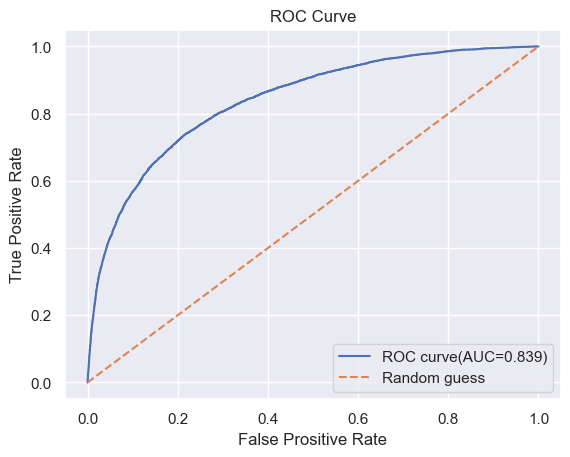

In [233]:
plt.figure()
plt.plot(fpr, tpr, label=f"ROC curve(AUC={auc:.3f})")
plt.plot([0,1],[0,1], linestyle="--", label="Random guess")
plt.xlabel("False Prositive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

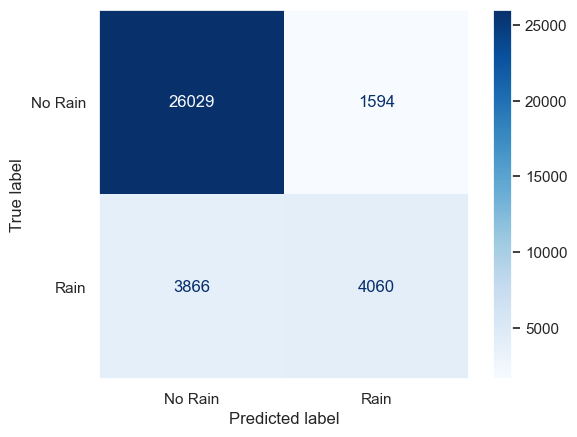

In [235]:
ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    display_labels=['No Rain', 'Rain'],
    cmap='Blues'
)
plt.grid(False)
plt.show()

## XGBoost Classifier ##

### Baseline ###

In [236]:
xgb = XGBClassifier(random_state=42)

xgb.fit(X_train_fl, y_train)
y_pred_xgb = xgb.predict(X_test_fl)
y_pred_xgb

array([1, 0, 0, ..., 0, 0, 1])

In [237]:
print(classification_report(y_test,y_pred_xgb))

              precision    recall  f1-score   support

           0       0.88      0.95      0.91     27623
           1       0.76      0.55      0.64      7926

    accuracy                           0.86     35549
   macro avg       0.82      0.75      0.77     35549
weighted avg       0.85      0.86      0.85     35549



In [239]:
y_proba_xgb = xgb.predict_proba(X_test_fl)[:,1]

auc = roc_auc_score(y_test, y_proba_xgb)
print("ROC_AUC", auc)

ROC_AUC 0.8903361277714673


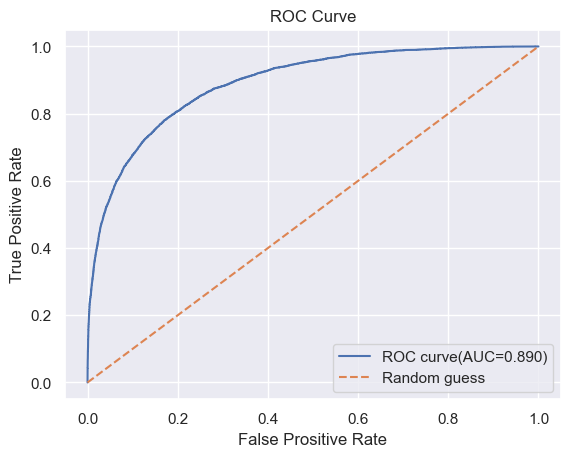

In [240]:
fpr, tpr, _ = roc_curve(y_test, y_proba_xgb)

plt.figure()
plt.plot(fpr, tpr, label=f"ROC curve(AUC={auc:.3f})")
plt.plot([0,1],[0,1], linestyle="--", label="Random guess")
plt.xlabel("False Prositive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

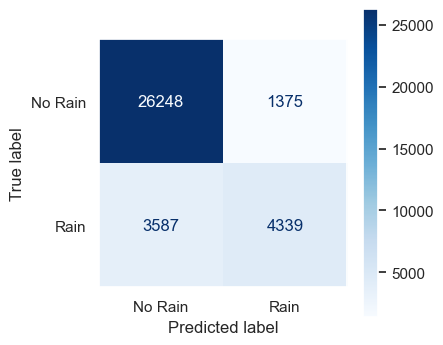

In [246]:
fig,ax = plt.subplots(figsize=(4,4)) 

ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred_xgb,
    display_labels=['No Rain', 'Rain'],
    cmap='Blues',
    ax=ax
)
plt.grid(False)
plt.show()

### Hyperparameter Tuning ###

In [248]:
xgb_params = {
    'n_estimators': [10,35,100],
    'max_depth': [5,10,15],
    'learning_rate': [0.01,0.1,0.25]
}
xgb_gs = GridSearchCV(xgb,xgb_params, scoring='accuracy', cv=3)
xgb_gs.fit(X_train_fl, y_train)

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, feature_weights=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None, ...),
             param_grid={'learning_rate': [0.01, 0.1, 0.25],
                         'max_depth': [5, 10, 15],
                         'n_estimators': [10, 35, 100]},
             scoring='accuracy')

In [249]:
xgb_gs.best_params_

{'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 100}

In [250]:
round(xgb_gs.best_score_,4)

np.float64(0.8633)

In [251]:
y_pred_xgb_gs = xgb_gs.predict(X_test_fl)
y_pred_xgb_gs

array([1, 0, 0, ..., 0, 0, 1])

In [252]:
print(classification_report(y_test,y_pred_xgb_gs))

              precision    recall  f1-score   support

           0       0.88      0.95      0.91     27623
           1       0.77      0.53      0.63      7926

    accuracy                           0.86     35549
   macro avg       0.82      0.74      0.77     35549
weighted avg       0.85      0.86      0.85     35549



In [253]:
y_proba_xgb_gs = xgb.predict_proba(X_test_fl)[:,1]

auc = roc_auc_score(y_test, y_proba_xgb_gs)
print("ROC_AUC", auc)

ROC_AUC 0.8903361277714673


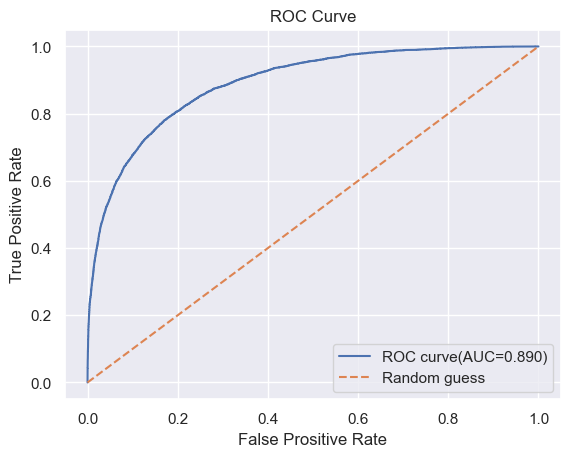

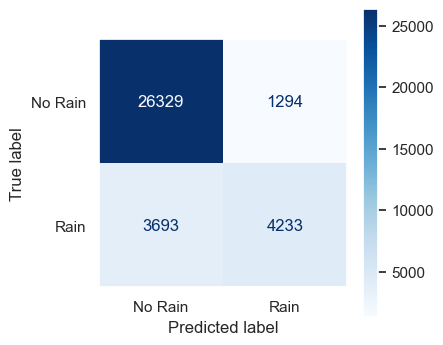

In [291]:
fpr, tpr, _ = roc_curve(y_test, y_proba_xgb_gs)

plt.figure()
plt.plot(fpr, tpr, label=f"ROC curve(AUC={auc:.3f})")
plt.plot([0,1],[0,1], linestyle="--", label="Random guess")
plt.xlabel("False Prositive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.savefig('images/ROC_curve_XGBoost_GS.png', 
            facecolor='white', dpi=150, bbox_inches='tight')


fig,ax = plt.subplots(figsize=(4,4))
ConfusionMatrixDisplay.from_predictions(y_test,y_pred_xgb_gs,display_labels=['No Rain', 'Rain'],cmap='Blues',ax=ax)
plt.grid(False)
plt.savefig('images/ConfusionMatrix_XGBoost_GS.png', facecolor='white', dpi=100);
plt.show()

### Feature Importance ###

In [259]:
best_xgb = xgb_gs.best_estimator_

In [260]:
importances = best_xgb.feature_importances_

In [262]:
import numpy as np
indices = np.argsort(importances)[::-1]

<Figure size 640x480 with 0 Axes>

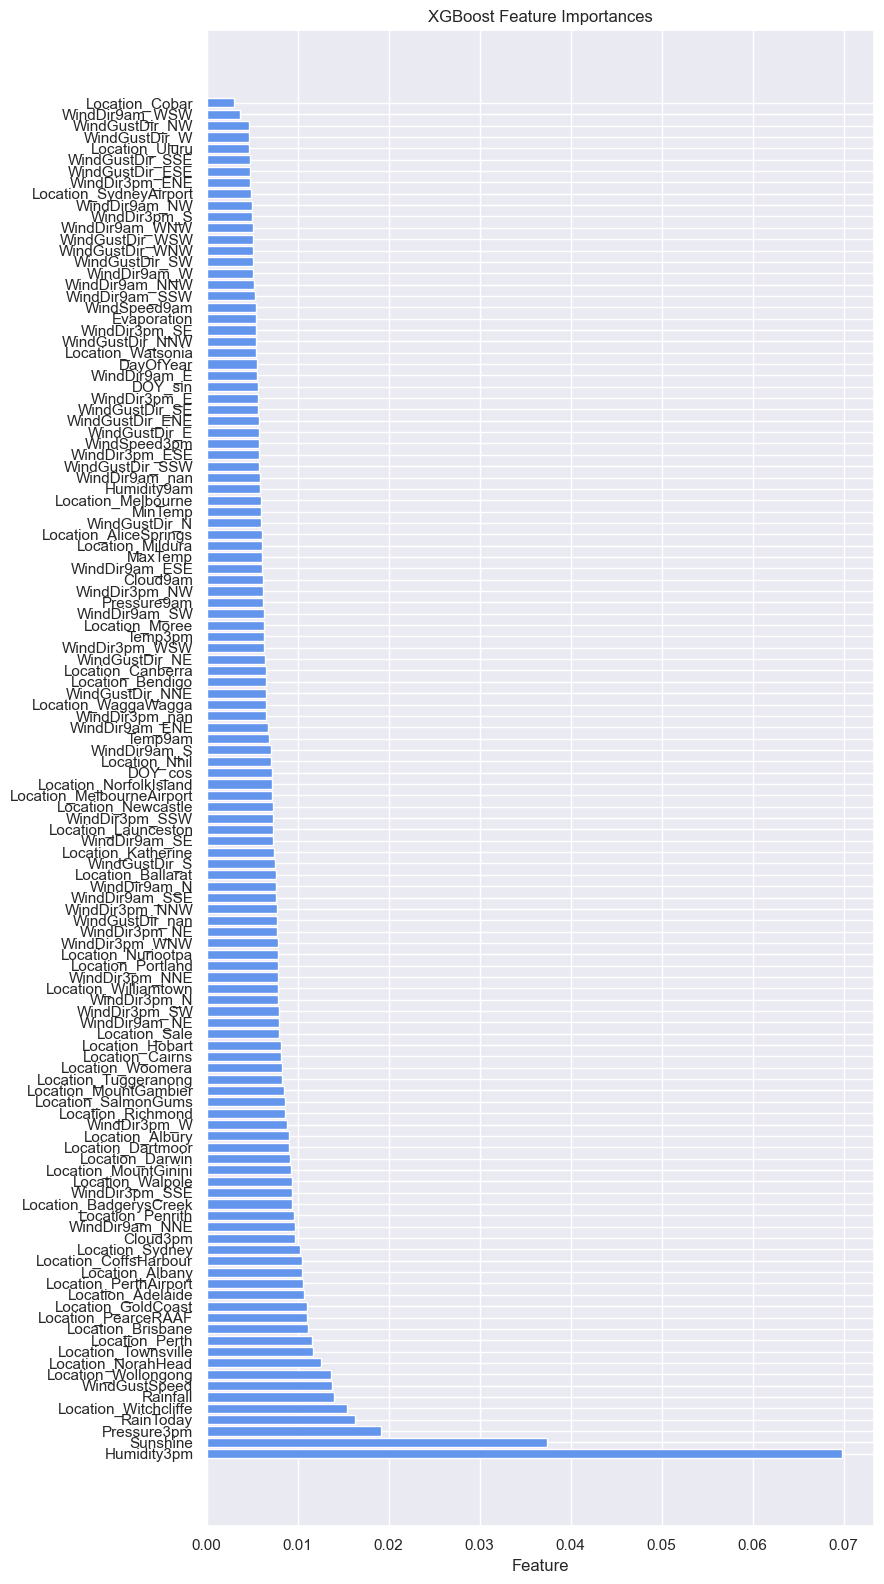

In [271]:
plt.clf()
plt.figure(figsize=(9,16))
plt.barh(
    y = range(len(indices)),
    width = importances[indices],
    color = 'cornflowerblue',
    align = 'center'
)

feature_names = X_train_fl.columns.values
plt.yticks(range(len(indices)), feature_names[indices])
plt.xlabel('Feature Importance')
plt.xlabel('Feature')
plt.title('XGBoost Feature Importances')
plt.tight_layout()
plt.show()

In [276]:
feat_imp_df = pd.DataFrame(data={
    'Feature': X_train_fl.columns,
    'Importance': best_xgb.feature_importances_
})

In [277]:
feat_imp_df['Group'] = feat_imp_df.Feature.apply(lambda x:x.split('_')[0])
feat_imp_df

,Feature,Importance,Group
0,MinTemp,0.005984,MinTemp
1,MaxTemp,0.006053,MaxTemp
2,Rainfall,0.013979,Rainfall
3,Evaporation,0.005397,Evaporation
4,Sunshine,0.037457,Sunshine
...,...,...,...
115,Location_Wollongong,0.013638,Location
116,Location_Woomera,0.008235,Location
117,DayOfYear,0.005567,DayOfYear
118,DOY_sin,0.005630,DOY


In [278]:
feat_imp_df.Group.value_counts()

Group
Location         49
WindGustDir      17
WindDir9am       17
WindDir3pm       17
DOY               2
MaxTemp           1
MinTemp           1
WindSpeed9am      1
WindGustSpeed     1
Sunshine          1
Evaporation       1
Rainfall          1
WindSpeed3pm      1
Humidity3pm       1
Humidity9am       1
Temp9am           1
Cloud3pm          1
Cloud9am          1
Pressure3pm       1
Pressure9am       1
RainToday         1
Temp3pm           1
DayOfYear         1
Name: count, dtype: int64

In [279]:
feat_imp_df_grouped = feat_imp_df.groupby(by='Group').sum()
feat_imp_df_grouped.sort_values('Importance', ascending = False ,inplace = True)
feat_imp_df_grouped

,Feature,Importance
Group,,
Location,Location_AdelaideLocation_AlbanyLocation_Albur...,0.418850
WindDir3pm,WindDir3pm_EWindDir3pm_ENEWindDir3pm_ESEWindDi...,0.118402
WindDir9am,WindDir9am_EWindDir9am_ENEWindDir9am_ESEWindDi...,0.107245
WindGustDir,WindGustDir_EWindGustDir_ENEWindGustDir_ESEWin...,0.096701
Humidity3pm,Humidity3pm,0.069841
Sunshine,Sunshine,0.037457
Pressure3pm,Pressure3pm,0.019214
RainToday,RainToday,0.016356
Rainfall,Rainfall,0.013979


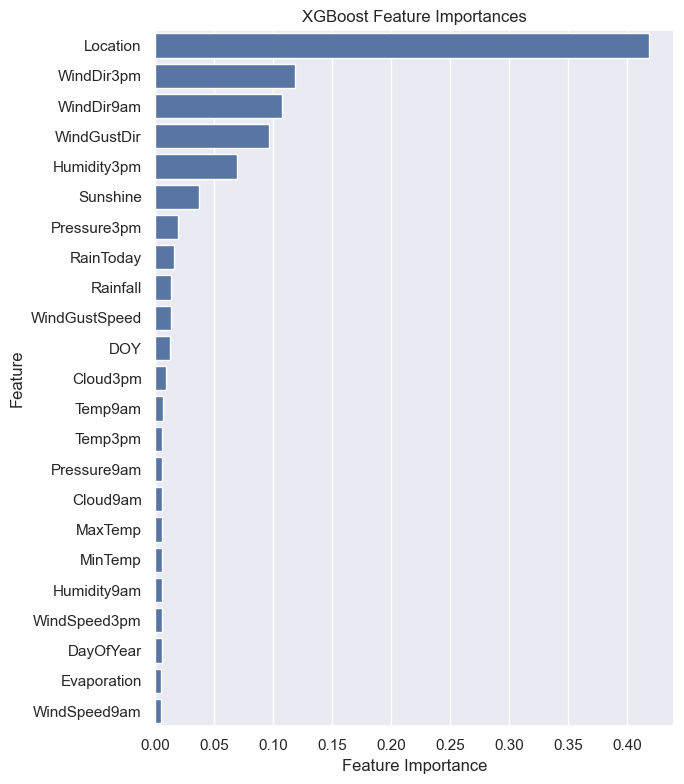

In [284]:
plt.figure(figsize=(7,8))
sns.barplot(y = feat_imp_df_grouped.index,
            x = feat_imp_df_grouped.Importance,
            orient = 'h',
            color = sns.color_palette()[0]
           )
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('XGBoost Feature Importances')
plt.tight_layout()
plt.savefig('images/feat_importances.png', facecolor='white', dpi=100);
plt.show()